In [2]:
import torch
import pickle

import numpy as np
from copy import copy, deepcopy
from utils.vmf_batch import vMF
from models import PoolingClassifier
from utils.rw_utils import load_neurons
from utils.cluster_utils import _convert_cluster_results_dict_into_array, get_clustered_rws_agglom, tree_from_clustered_result
from utils.sampling_utils import _fill_with_infty, decode_z, sample_rws

from utils.training_utils import create_model

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
#load in data
neurons = load_neurons('./data/toy_data/3_populations/neurons/')

In [3]:
z = neurons[0]

In [4]:
z.to_swc()

,n,type,x,y,z,radius,parent
0,0,1,0.00,0.00,0.00,1.0,-1
1,1,3,0.32,-0.55,0.30,1.0,0
2,2,3,0.64,-0.10,1.14,1.0,1
3,3,3,0.96,0.36,0.68,1.0,2
4,4,3,1.30,0.33,1.53,1.0,3
...,...,...,...,...,...,...,...
395,395,3,-3.39,-0.34,1.01,1.0,342
396,396,3,-3.36,-0.79,2.48,1.0,343
397,397,3,-3.46,1.64,1.33,1.0,344
398,398,3,-3.39,-1.46,2.04,1.0,345


In [10]:
with open('./data/toy_data/3_populations/walk_representation_8.npy', 'rb') as f:
    walk_representation = np.load(f)

In [11]:
with open('./data/toy_data/3_populations/iterator/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/toy_data/3_populations/iterator/test_iterator.pkl', 'rb') as f:
    test_iterator = pickle.load(f)

In [12]:
SEED = 17
# get data
np.random.seed(SEED)
torch.random.manual_seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(test_iterator)[0]
rw_i = np.round(trg_data, 2)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=16, hidden_dim=16, latent_dim=8, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)

KLD: 18.465579986572266


In [7]:
state_dict = torch.load('./models/3_populations/emb32_hid32_lat32_dp0.1_k500_max_frac1.0_run1_best.pt')
model.load_state_dict(state_dict['model_state_dict'])
model.eval()
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)

FileNotFoundError: [Errno 2] No such file or directory: './models/3_populations/emb32_hid32_lat32_dp0.1_k500_max_frac1.0_run1_best.pt'

In [ ]:
with open('./models/3_populations/losses_emb32_hid32_lat32_dp0.1_k500_max_frac1.0_1.npy', 'rb') as f:
    l1 = np.load(f)

In [ ]:
np.min(l1[:,2] - l1[:,3])

## sample neurons

In [ ]:
rw_0 = _fill_with_infty(rw_i.reshape(-1,walk_length,3).transpose(0,1), seq_len.reshape(-1))
rw_i = rw_0.transpose(0,1).reshape(-1,n_walks,walk_length, 3)

In [ ]:
indices_0 = np.where(labels == 0)[0]
indices_1 = np.where(labels == 1)[0]
indices_2 = np.where(labels == 2)[0]

In [ ]:
sns.set_context("notebook")

In [ ]:
np.random.seed(SEED)
random_indices = np.array([np.random.choice(indices_0, size=2),
                                 np.random.choice(indices_1, size=2),
                                 np.random.choice(indices_2, size=2)])
random_indices = random_indices.flatten()

KLD: 18.465579986572266


NameError: name 'get_no_intersections' is not defined

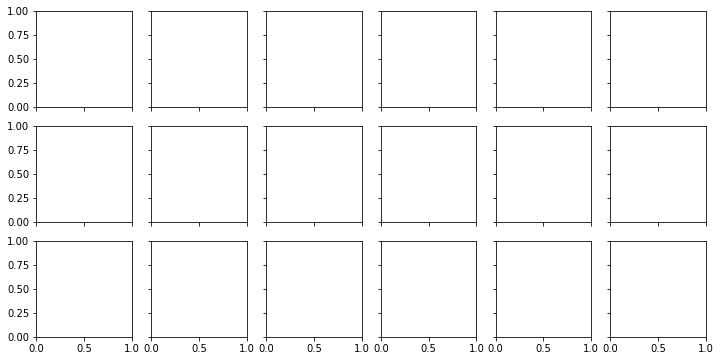

In [20]:
# this was obtained with threshold .5 and merging
fig, axes = plt.subplots(3,6, sharex=True, sharey=True, figsize=(12,6))
axes = axes.flatten()

colors = sns.color_palette('pink', n_colors=4)

vmf = vMF(LATENT_DIM, kappa=500)
np.random.seed(SEED)
k = 0
for ix in random_indices:                   
    rw_rep = rw_i[ix]
    no_intersection = get_no_intersections(rw_rep)
    # get the encoded random walks. This only works if I have passed the data through already
    mus = model.h[ix*n_walks: ix*n_walks+n_walks]
    original_seq_len = seq_len[ix*n_walks: ix*n_walks+n_walks].cpu()
    decoded_rws = sample_rws(model,vmf, mus, orig_seq_len=original_seq_len, 
                             n_samples=2, max_trg_len=walk_length, min_angle=np.pi/2.4)
    
    # cluster the rws
    clustered_rws = []
    clustered_results = []
    for rws in decoded_rws:
        clus_res, clus_rws = get_clustered_rws_agglom(rws,dist_thresh=.5 )
        clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
        clustered_results.append(clus_res)
    clustered_rws = np.vstack(clustered_rws)
    # reduce to trees
    new_neurons = []
    for clus_res in clustered_results:
        N = tree_from_clustered_result(clus_res)
        new_neurons.append(N)
    
    if k == 0 or k ==3:
        c= colors[0]
    elif k == 6 or k ==9:
        c= colors[1]
    elif k == 12 or k ==15:
        c= colors[2]    
    
    neurons[indices[ix]].draw_2D(ax=axes[k], dendrite_color=c, projection='xy')

    axes[k].axis('off')

    for l in range(k+1,k+3):
        
        sampled_rws = decoded_rws[l-k-1]
        axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,1].T, c='darkgrey')
        axes[l].axis('off')
        axes[l].set_aspect('equal')
        new_neurons[l-k-1].draw_2D(projection='xy', dendrite_color='k', ax=axes[l])
    k += 3
fig.subplots_adjust(hspace=-.1, wspace=-.1)
#plt.savefig('./pics/ICML/v3/Fig5/toy_data_reconstructions.svg', format='svg')

# On real data

In [ ]:
neurons = load_neurons('./data/M1_exc_data/neurons/', sort=False)

colors =['#338b5f', 
        '#0d5d7f',
        '#55b7a6']

In [ ]:
with open('./data/M1_exc_data/walks/walk_representation.npy', 'rb') as f:
    walk_representation = np.load(f)

with open('./data/M1_exc_data/iterator/m_labels/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/M1_exc_data/iterator/m_labels/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/M1_exc_data/iterator/m_labels/test_iterator.pkl', 'rb') as f:
    test_iterator = pickle.load(f)

In [ ]:
SEED = 17
# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, input_dim = src_data.shape

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)

LATENT_DIM = config['latent_dim']

# model with the best validation loss 
state_dict = torch.load('./models/M1_exc/m_label/finetuned_vae_k500_frac1.0_best_run2.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict['model_state_dict'])


In [ ]:
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)

In [ ]:
rw_0 = _fill_with_infty(rw_i.reshape(-1,walk_length,input_dim).transpose(0,1), seq_len.reshape(-1))
rw_i = rw_0.transpose(0,1).reshape(-1,n_walks,walk_length, input_dim)

In [ ]:
indices_0 = np.where(labels == 0)[0]
indices_1 = np.where(labels == 1)[0]
indices_2 = np.where(labels == 2)[0]

In [ ]:
# sample one neuron and check how it looks
model.eval()
vmf = vMF(LATENT_DIM, kappa=500)
ix =8
rw_rep = rw_i[ix]
walk_length=32

# get the encoded random walks. This only works if I have passed the data through already
mus = model.h[ix*n_walks: ix*n_walks+n_walks]
orig_seq_len = seq_len[ix*n_walks: ix*n_walks+n_walks].cpu()
decoded_rws = sample_rws(model, vmf, mus, orig_seq_len=orig_seq_len,
                         n_samples=3, max_trg_len=walk_length, min_angle=np.pi/2.4)

# cluster the rws
clustered_rws = []
clustered_results = []
stems = len(neurons[ix].edges(1))
for rws in decoded_rws:
    clus_res, clus_rws = get_clustered_rws_agglom(rws, dist_thresh=.4)
#     clus_res = cluster_rws_soma2tip(rws, stems,dist_thresh=1.2)
    clus_rws = _convert_cluster_results_dict_into_array(rws.shape, clus_res)
    clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
    clustered_results.append(clus_res)
clustered_rws = np.vstack(clustered_rws)
# reduce to trees
new_neurons = []
for clus_res in clustered_results:
    N = tree_from_clustered_result(clus_res)
    new_neurons.append(N)
    
    
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,4))
neurons[indices[ix]].draw_2D(ax=axes[0], dendrite_color='k', projection='xz')
axes[0].plot(rw_rep[:,:,0].T, rw_rep[:,:,2].T, c='darkgrey')
axes[0].axis('off')
axes[0].set_aspect('equal')

for l in range(1,4):    
    sampled_rws = decoded_rws[l-1]
    axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
    axes[l].axis('off')
    new_neurons[l-1].draw_2D(projection='xz', dendrite_color='k', ax=axes[l])
    axes[l].set_aspect('equal')
fig.subplots_adjust( wspace=-.1)

In [ ]:
### Code for plotting single examples

fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(4,4))
l = 1
neurons[indices[ix]].draw_2D(ax=axes[0], dendrite_color=colors[l], projection='xz')
axes[0].axis('off')
axes[0].set_aspect('equal')

inset_axis = axes[0].inset_axes([.7,.8,.5,.5])
neurons[indices[ix]].draw_2D(ax=inset_axis, dendrite_color=colors[l], projection='xy', linewidth=2)
inset_axis.axis('off')
inset_axis.set_aspect('equal')

d_ix = 0
sampled_rws = decoded_rws[d_ix]
axes[1].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
axes[1].axis('off')
new_neurons[d_ix].draw_2D(projection='xz', dendrite_color='k', ax=axes[1],linewidth=2)
axes[1].set_aspect('equal')

inset_axis_sample = axes[1].inset_axes([.7,.8,.5,.5])
# inset_axis_sample.plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
new_neurons[d_ix].draw_2D(ax=inset_axis_sample, dendrite_color='k', projection='xy',linewidth=2)
inset_axis_sample.axis('off')
inset_axis_sample.set_aspect('equal')

fig.subplots_adjust( wspace=-.1)
plt.tight_layout()
plt.savefig('./pics/ICML/camera-ready/Fig6/untufted_example_1.svg')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# plotting 2 examples per class
np.random.seed(SEED-10)
# np.random.seed(SEED-2)
random_indices = np.array([np.random.choice(indices_0, size=2, replace=False),
                                 np.random.choice(indices_1, size=2,replace=False),
                                 np.random.choice(indices_2, size=2,replace=False)])
random_indices = random_indices.flatten()
random_indices

colors =['#338b5f', 
        '#0d5d7f',
        '#55b7a6']

fig, axes = plt.subplots(3,6, sharex=True, sharey=True, figsize=(18,9))
axes = axes.flatten()
model.eval()
vmf = vMF(LATENT_DIM, kappa=500)

k = 0
for ix in random_indices:                   
    rw_rep = rw_i[ix]

    # get the encoded random walks. This only works if I have passed the data through already
    mus = model.h[ix*n_walks: ix*n_walks+n_walks]
    decoded_rws = sample_rws(model, vmf, mus, n_samples=2, max_trg_len=walk_length, min_angle=np.pi/2.4)
    
    # cluster the rws
    clustered_rws = []
    clustered_results = []
    for rws in decoded_rws:
        clus_res, clus_rws = get_clustered_rws_agglom(rws, dist_thresh=.4)
        clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
        clustered_results.append(clus_res)
    clustered_rws = np.vstack(clustered_rws)
    # reduce to trees
    new_neurons = []
    for clus_res in clustered_results:
        N = tree_from_clustered_result(clus_res)
        new_neurons.append(N)
    
    if k == 0 or k ==3:
        c= colors[0]
    elif k == 6 or k ==9:
        c= colors[1]
    elif k == 12 or k ==15:
        c= colors[2]  
    
    neurons[indices[ix]].draw_2D(ax=axes[k], dendrite_color=c, projection='xz')
    #_ = axes[k].plot(rw_rep[:,:,0].T, rw_rep[:,:,2].T, c='grey', alpha=.1)
    axes[k].axis('off')

    for l in range(k+1,k+3):
        
        sampled_rws = decoded_rws[l-k-1]
        axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
        axes[l].axis('off')
        axes[l].set_aspect('equal')
        new_neurons[l-k-1].draw_2D(projection='xz', dendrite_color='k', ax=axes[l])
    k += 3
fig.subplots_adjust(hspace=-.1, wspace=-.2)
# plt.savefig('./pics/ICML/v4/Fig6/pyr_data_reconstructions.svg', format='svg')

# Inhibitory neurons - fine tuned

In [ ]:
torch.cuda.empty_cache()
colors = ['#fd9e2b', '#e0285d', '#aa369a', '#fda389']

part = 'axon'
neurons = load_neurons('./data/M1_inh_data/neurons/%s/'%part, sort=False)

In [ ]:
with open('./data/M1_inh_data/walks/%s/walk_representation_32.npy'%part, 'rb') as f:
    walk_representation = np.load(f)

with open('./data/M1_inh_data/iterator/%s/train_iterator_32.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/M1_inh_data/iterator/%s/val_iterator_32.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/M1_inh_data/iterator/%s/test_iterator_32.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)

In [ ]:
SEED = 17

# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(val_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, input_dim = src_data.shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=32, hidden_dim=32, latent_dim=32, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)

LATENT_DIM = config['latent_dim']

# model with the best validation mse loss 
state_dict = torch.load('./models/M1_inh/finetuned/%s/finetuned_vae_frac0.5_best_run2.pt'%part)
model.load_state_dict(state_dict['model_state_dict'])

In [ ]:
# pass the data through the model so we can sample new examples in the the latent space
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)
    
rw_0 = _fill_with_infty(rw_i.reshape(-1,walk_length,input_dim).transpose(0,1), seq_len.reshape(-1))
rw_i = rw_0.transpose(0,1).reshape(-1,n_walks,walk_length, input_dim)

In [ ]:
indices_0 = np.where(labels == 0)[0]
indices_1 = np.where(labels == 1)[0]
indices_2 = np.where(labels == 2)[0]
indices_3 = np.where(labels == 3)[0]

np.random.seed(SEED-2)
random_indices = np.array([np.random.choice(indices_0, size=2, replace=False),
                                 np.random.choice(indices_1, size=2,replace=False),
                                 np.random.choice(indices_2, size=2,replace=False), 
                                np.random.choice(indices_3, size=2,replace=False)])
random_indices = random_indices.flatten()

In [ ]:
np.where(labels == 3)[0]

In [ ]:
# sample one neuron and check how it looks
model.eval()
vmf = vMF(LATENT_DIM, kappa=500)
ix = 48
rw_rep = rw_i[ix]
walk_length=32
# get the encoded random walks. This only works if I have passed the data through already
mus = model.h[ix*n_walks: ix*n_walks+n_walks]
orig_seq_len = seq_len[ix*n_walks: ix*n_walks+n_walks].cpu()
decoded_rws = sample_rws(model, vmf, mus, orig_seq_len=orig_seq_len,
                         n_samples=3, max_trg_len=walk_length, min_angle=np.pi/2.4)

# cluster the rws
clustered_rws = []
clustered_results = []
for rws in decoded_rws:
    clus_res, clus_rws = get_clustered_rws_agglom(rws, dist_thresh=.3)
    clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
    clustered_results.append(clus_res)
clustered_rws = np.vstack(clustered_rws)
# reduce to trees
new_neurons = []
for clus_res in clustered_results:
    N = tree_from_clustered_result(clus_res)
    new_neurons.append(N)
    
    
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,4))
neurons[indices[ix]].draw_2D(ax=axes[0], dendrite_color='k', projection='xz')
axes[0].plot(rw_rep[:,:,0].T, rw_rep[:,:,2].T, c='darkgrey')
axes[0].axis('off')
axes[0].set_aspect('equal')

for l in range(1,4):    
    sampled_rws = decoded_rws[l-1]
    axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
    axes[l].axis('off')
    new_neurons[l-1].draw_2D(projection='xz', dendrite_color='k', ax=axes[l])
    axes[l].set_aspect('equal')
fig.subplots_adjust( wspace=-.1)

In [ ]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(4,4))
l = 3
neurons[indices[ix]].draw_2D(ax=axes[0], axon_color=colors[l], projection='xz')
axes[0].axis('off')
axes[0].set_aspect('equal')

inset_axis = axes[0].inset_axes([.9,.7,.5,.5])
neurons[indices[ix]].draw_2D(ax=inset_axis, axon_color=colors[l], projection='xy')
inset_axis.axis('off')
# inset_axis.set_aspect('equal')

d_ix = 0
sampled_rws = decoded_rws[d_ix]
axes[1].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
axes[1].axis('off')
new_neurons[d_ix].draw_2D(projection='xz', dendrite_color='k', ax=axes[1])
axes[1].set_aspect('equal')

inset_axis_sample = axes[1].inset_axes([.9,.7,.5,.5])
# inset_axis_sample.plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
new_neurons[d_ix].draw_2D(ax=inset_axis_sample, dendrite_color='k', projection='xy')
inset_axis_sample.axis('off')
inset_axis_sample.set_aspect('equal')

# fig.subplots_adjust( wspace=-.1)
plt.savefig('./pics/ICML/camera-ready/Fig6/lamp5_example2.svg')

In [ ]:
colors = ['#fd9e2b', '#e0285d', '#aa369a', '#fda389']
fig, axes = plt.subplots(4,6, sharex=True, sharey=True, figsize=(24,9))
axes = axes.flatten()
model.eval()
vmf_500 = vMF(LATENT_DIM, kappa=500)

k = 0
for ix in random_indices:                   
    rw_rep = rw_i[ix]

    # get the encoded random walks. This only works if I have passed the data through already
    mus = model.h[ix*n_walks: ix*n_walks+n_walks]
    decoded_rws = sample_rws(vmf_500, mus, n_samples=2, max_trg_len=walk_length, min_angle=np.pi/2.4)
    
    # cluster the rws
    clustered_rws = []
    clustered_results = []
    for rws in decoded_rws:
        clus_res, clus_rws = get_clustered_rws_agglom(rws, dist_thresh=.25)
        clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
        clustered_results.append(clus_res)
    clustered_rws = np.vstack(clustered_rws)
    # reduce to trees
    new_neurons = []
    for clus_res in clustered_results:
        N = tree_from_clustered_result(clus_res)
        new_neurons.append(N)
    
    if k == 0 or k ==3:
        c= colors[0]
    elif k == 6 or k ==9:
        c= colors[1]
    elif k == 12 or k ==15:
        c= colors[2]  
    
    neurons[indices[ix]].draw_2D(ax=axes[k], axon_color=c, projection='xz')
    axes[k].axis('off')

    for l in range(k+1,k+3):
        
        sampled_rws = decoded_rws[l-k-1]
        axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,2].T, c='darkgrey')
        axes[l].axis('off')
        new_neurons[l-k-1].draw_2D(projection='xz', dendrite_color='k', ax=axes[l])
    k += 3
fig.subplots_adjust(hspace=-.2, wspace=-.2)

# Farrow - fine tuned

In [9]:
import os

In [10]:
part = 'soma_centered'
neurons = np.array(load_neurons('./data/Farrow_data/neurons/%s/'%part, sort=False))

# get the neuron files in the right order
root, _, files = list(os.walk('./data/Farrow_data/neurons/%s/'%part))[0]
files = np.array(files)
file_ix = files.argsort()
neurons = neurons[file_ix]

with open('./data/Farrow_data/walks/%s/walk_representation.npy'%part, 'rb') as f:
    walk_representation = np.load(f)

with open('./data/Farrow_data/iterator/%s/train_iterator.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/Farrow_data/iterator/%s/val_iterator.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/Farrow_data/iterator/%s/test_iterator.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)

0002_00535_4L_C01_01-checkpoint.swc
0001_00535_1L_C01_01-checkpoint.swc


In [11]:
SEED = 17

# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(test_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, input_dim = src_data.shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=16, hidden_dim=16, latent_dim=8, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)

LATENT_DIM = config['latent_dim']

# model with the best validation mse loss 
state_dict = torch.load('./models/Farrow/finetuned/%s/finetuned_vae_frac1.0_best_run1.pt'%part)
model.load_state_dict(state_dict['model_state_dict'])

KLD: 18.465579986572266


<All keys matched successfully>

In [12]:
np.unique(labels, return_counts = True)

(array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
          10,   11,   12,   13]),
 array([ 6, 20,  1,  2,  5,  5, 15,  2,  9,  5,  5,  4,  8, 11,  2]))

In [13]:
rw_0 = _fill_with_infty(rw_i.reshape(-1,walk_length,input_dim).transpose(0,1), seq_len.reshape(-1))
rw_i = rw_0.transpose(0,1).reshape(-1,n_walks,walk_length, input_dim)

indices_0 = np.where(labels == 0)[0]
indices_1 = np.where(labels == 4)[0]
indices_2 = np.where(labels == 5)[0]
indices_3 = np.where(labels == 12)[0]

np.random.seed(SEED)

random_indices = np.array([np.random.choice(indices_0, size=2, replace=False),
                                 np.random.choice(indices_1, size=2,replace=False),
                                 np.random.choice(indices_2, size=2,replace=False), 
                                np.random.choice(indices_3, size=2,replace=False)])
random_indices = random_indices.flatten()

In [17]:
indices_1

array([25, 37, 80, 86, 92])

In [14]:
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)

KLD: 18.465579986572266


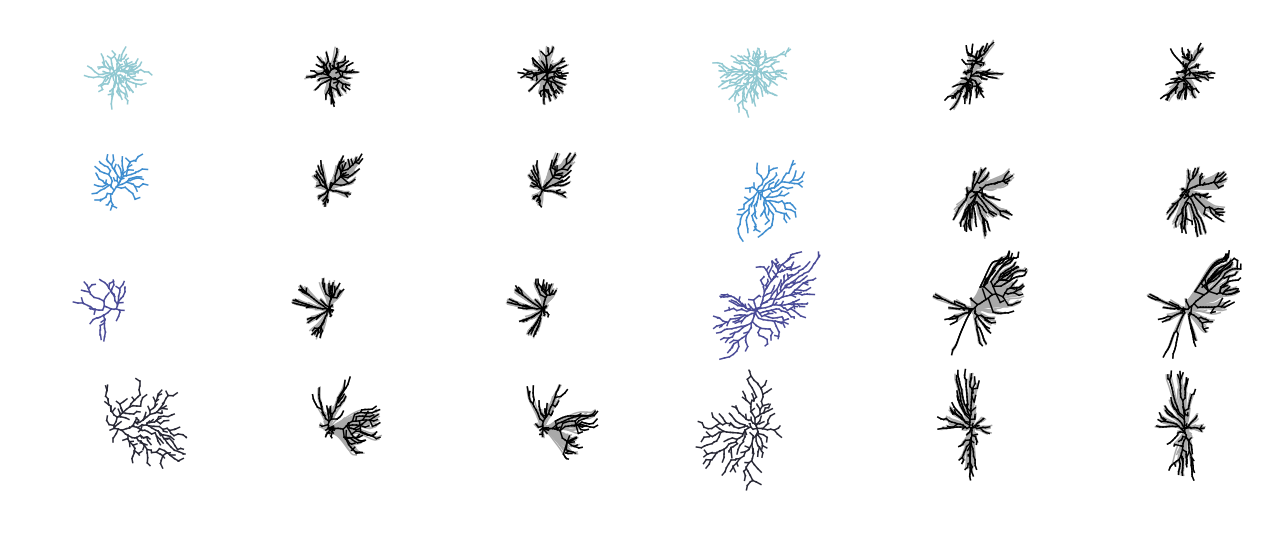

In [15]:
colors = sns.color_palette('icefire', n_colors=15)
fig, axes = plt.subplots(4,6, sharex=True, sharey=True, figsize=(24,9))
axes = axes.flatten()
model.eval()
vmf = vMF(LATENT_DIM, kappa=500)

k = 0
for ix in random_indices:                   
    rw_rep = rw_i[ix]

    # get the encoded random walks. This only works if I have passed the data through already
    mus = model.h[ix*n_walks: ix*n_walks+n_walks]
    orig_seq_len = seq_len[ix*n_walks: ix*n_walks+n_walks].cpu()
    decoded_rws = sample_rws(model, vmf, mus, orig_seq_len=orig_seq_len ,
                             n_samples=2, max_trg_len=walk_length, min_angle=np.pi/2.4, init_state=trg[0,ix*n_walks])
    
    # cluster the rws
    clustered_rws = []
    clustered_results = []
    for rws in decoded_rws:
        clus_res, clus_rws = get_clustered_rws_agglom(rws, dist_thresh=.25)
        clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
        clustered_results.append(clus_res)
    clustered_rws = np.vstack(clustered_rws)
    # reduce to trees
    new_neurons = []
    for clus_res in clustered_results:
        N = tree_from_clustered_result(clus_res)
        new_neurons.append(N)
    
    if k == 0 or k ==3:
        c= colors[0]
    elif k == 6 or k ==9:
        c= colors[2]
    elif k == 12 or k ==15:
        c= colors[4]  
    elif k == 18 or k ==21:
        c= colors[6]
    
    neurons[indices[ix]].draw_2D(ax=axes[k], dendrite_color=c, projection='xy')
    axes[k].axis('off')
    axes[k].set_aspect('equal')
    
    for l in range(k+1,k+3):
        
        sampled_rws = decoded_rws[l-k-1]
        axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,1].T, c='darkgrey')
        axes[l].axis('off')
        axes[l].set_aspect('equal')
        new_neurons[l-k-1].draw_2D(projection='xy', dendrite_color='k', ax=axes[l])
    k += 3
fig.subplots_adjust(hspace=-.1, wspace=-.2)

### urban data - finetuned

In [3]:
import os

part = 'soma_centered'
neurons = np.array(load_neurons('./data/urban_data/neurons/%s/'%part, sort=False))

# get the neuron files in the right order
root, _, files = list(os.walk('./data/urban_data/neurons/%s/'%part))[0]
files = np.array(files)
file_ix = files.argsort()
neurons = neurons[file_ix]

with open('./data/urban_data/walks/%s/walk_representation_8.npy'%part, 'rb') as f:
    walk_representation = np.load(f)

with open('./data/urban_data/iterator/%s/train_iterator.pkl'%part, 'rb') as f:
    train_iterator = pickle.load(f)
with open('./data/urban_data/iterator/%s/val_iterator.pkl'%part, 'rb') as f:
    val_iterator = pickle.load(f)
with open('./data/urban_data/iterator/%s/test_iterator.pkl'%part, 'rb') as f:
    test_iterator = pickle.load(f)

interneuron_basketSDB130903c5-neocortical-basket-cell-checkpoint.swc


In [55]:
SEED = 9

# get data
np.random.seed(SEED)
torch.manual_seed(SEED)
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
rw_i = np.round(trg_data, 2)

N, n_walks, walk_length, input_dim = src_data.shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = dict(input_dim =3, embed_dim=16, hidden_dim=16, latent_dim=8, num_layers = 2, kappa=500, dropout=.1)

model = create_model(config, device)

LATENT_DIM = config['latent_dim']

# model with the best validation mse loss 
state_dict = torch.load('./models/urban/finetuned/%s/finetuned_vae_frac1.0_best_run2.pt'%part)
model.load_state_dict(state_dict['model_state_dict'])

KLD: 18.465579986572266


<All keys matched successfully>

In [56]:
np.unique(labels, return_counts = True)

(array([0, 1, 2, 3, 4]), array([ 1, 20, 69, 36,  2]))

In [57]:
np.where(labels == 0)[0]

array([32])

In [68]:
rw_0 = _fill_with_infty(rw_i.reshape(-1,walk_length,input_dim).transpose(0,1), seq_len.reshape(-1))
rw_i = rw_0.transpose(0,1).reshape(-1,n_walks,walk_length, input_dim)

indices_0 = np.where(labels == 1)[0]
indices_1 = np.where(labels == 2)[0]
indices_2 = np.where(labels == 3)[0]
indices_3 = np.where(labels == 4)[0]
#indices_4 = np.where(labels == 4)[0]

np.random.seed(SEED)

random_indices = np.array([np.random.choice(indices_0, size=2, replace=False),
                                 np.random.choice(indices_1, size=2,replace=False),
                                 np.random.choice(indices_2, size=2,replace=False),
                                 np.random.choice(indices_3, size=2,replace=False)])
                                 #np.random.choice(indices_4, size=2,replace=False)]) 
random_indices = random_indices.flatten()

In [69]:
labels

tensor([4, 3, 3, 3, 2, 3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 2, 2, 2, 3, 2, 2, 0, 2, 2, 3, 2, 2, 2, 1, 1, 2, 4, 3, 2, 1, 2, 2,
        1, 2, 3, 1, 2, 1, 2, 3, 2, 2, 2, 2, 3, 1, 3, 2, 3, 2, 1, 2, 1, 3, 1, 3,
        3, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 2, 2,
        2, 3, 2, 3, 1, 3, 3, 3, 3, 2, 2, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 3, 1, 2,
        2, 2, 1, 3, 3, 2, 3, 3])

In [70]:
np.where(labels == 1)[0]

array([  7,  11,  16,  39,  40,  45,  48,  51,  53,  61,  66,  68,  70,
        76,  90, 100, 107, 110, 118, 122])

In [71]:
with torch.no_grad():
    bs, n_walks, walk_length, input_dim = src_data.shape
    src = src_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    # src = [walk length , bs * n_walks, input_dim]
    trg = trg_data.view(-1,walk_length,input_dim).transpose(0,1).to(device)
    seq_len = seq_len.view(-1).to(device)
    output = model(src, seq_len, trg, 0)

In [72]:
3584 / 256

14.0

KLD: 18.465579986572266


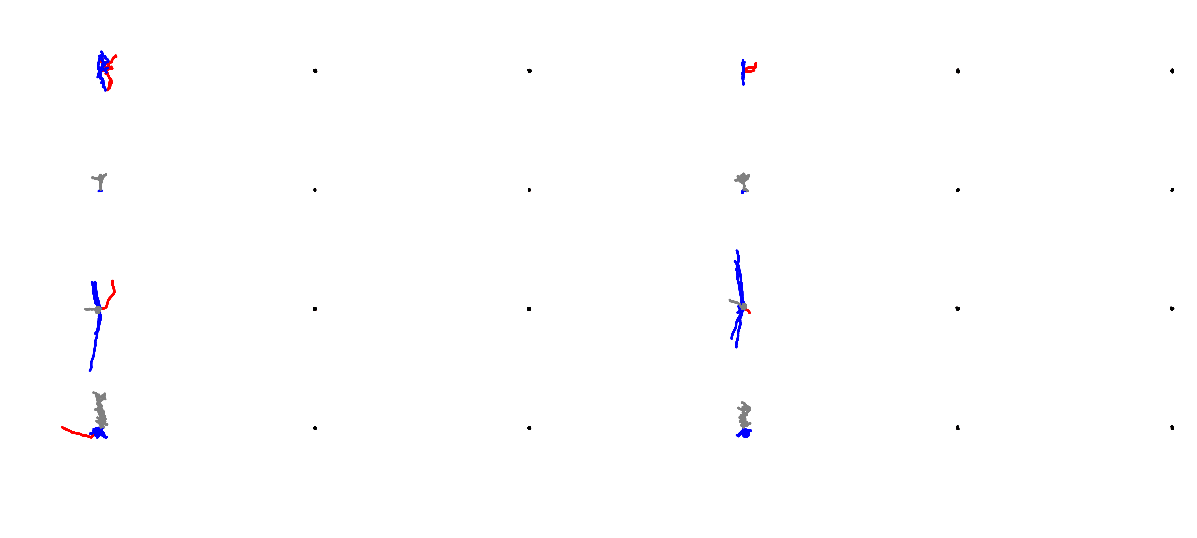

In [73]:
#colors = sns.color_palette('icefire', n_colors=15)
fig, axes = plt.subplots(4,6, sharex=True, sharey=True, figsize=(24,9))
axes = axes.flatten()
model.eval()
vmf = vMF(LATENT_DIM, kappa=500)

k = 0
for ix in random_indices:                   
    rw_rep = rw_i[ix]

    # get the encoded random walks. This only works if I have passed the data through already
    mus = model.h[ix*n_walks: ix*n_walks+n_walks]
    orig_seq_len = seq_len[ix*n_walks: ix*n_walks+n_walks].cpu()
    decoded_rws = sample_rws(model, vmf, mus, orig_seq_len=orig_seq_len ,
                             n_samples=2, max_trg_len=walk_length, min_angle=np.pi/2.4, init_state=trg[0,ix*n_walks])
    
    # cluster the rws
    clustered_rws = []
    clustered_results = []
    for rws in decoded_rws:
        clus_res, clus_rws = get_clustered_rws_agglom(rws, dist_thresh=.25)
        clustered_rws.append(clus_rws.reshape((1,)+clus_rws.shape))
        clustered_results.append(clus_res)
    clustered_rws = np.vstack(clustered_rws)
    # reduce to trees
    new_neurons = []
    for clus_res in clustered_results:
        N = tree_from_clustered_result(clus_res)
        new_neurons.append(N)
    
    #if k == 0 or k ==4:
    #    c= colors[0]
    #elif k == 6 or k ==9:
    #    c= colors[2]
    #elif k == 12 or k ==15:
    #    c= colors[4]  
    #elif k == 18 or k ==21:
    #    c= colors[6]
    
    neurons[indices[ix]].draw_2D(ax=axes[k], dendrite_color='b', axon_color='red',projection='xy')
    axes[k].axis('off')
    axes[k].set_aspect('equal')
    
    for l in range(k+1,k+3):
        
        sampled_rws = decoded_rws[l-k-1]
        axes[l].plot(sampled_rws[:,:,0].T, sampled_rws[:,:,1].T, c='red')
        axes[l].axis('off')
        axes[l].set_aspect('equal')
        new_neurons[l-k-1].draw_2D(projection='xy', dendrite_color='k', ax=axes[l])
    k += 3
fig.subplots_adjust(hspace=-.1, wspace=-.2)

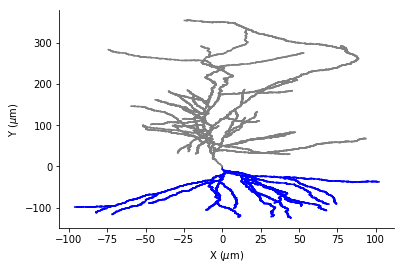

In [74]:
neurons[indices[ix]].draw_2D(projection='xy', dendrite_color='blue')

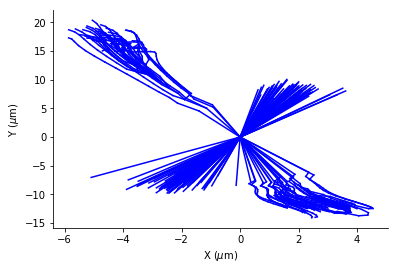

In [75]:
new_neurons[0].draw_2D(projection='xy', dendrite_color='blue')

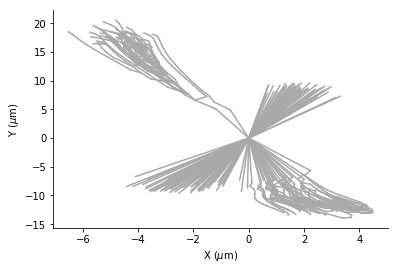

In [76]:
new_neurons[1].draw_2D(projection='xy')

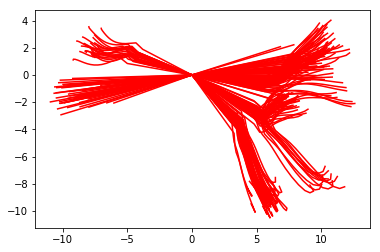

In [18]:
sampled_rws = decoded_rws[l-k-1]
plt.plot(sampled_rws[:,:,0].T, sampled_rws[:,:,1].T, c='red');

In [ ]:
from utils.cluster_utils import cluster_rws_soma2tip
cluster_result = cluster_rws_soma2tip(decoded_rws, n_intersections=10)

In [19]:
orig_seq_len

tensor([16., 16., 16., 16., 16., 16., 16., 16.,  2., 16., 16.,  2.,  2., 16.,
        16., 16., 16., 16., 16., 16., 16., 16., 16.,  2., 16., 16.,  2., 16.,
        16., 16.,  2., 16., 16.,  2., 16., 16.,  2., 16.,  2., 16.,  2., 16.,
        16., 16.,  2., 16.,  2., 16.,  2., 16.,  2., 16., 16., 16.,  2., 16.,
        16., 16., 16., 16., 16., 16., 16., 16.,  2., 16., 16., 16., 16., 16.,
         2., 16., 16., 16.,  2., 16., 16., 16., 16.,  2.,  2., 16., 16., 16.,
         2., 16., 16., 16.,  2., 16.,  2.,  2.,  2., 16., 16., 16., 16., 16.,
         2., 16., 16., 16., 16.,  2.,  2., 16., 16., 16.,  2., 16., 16., 16.,
         2., 16.,  2., 16., 16., 16., 16., 16.,  2.,  2.,  2.,  2., 16., 16.,
        16., 16., 16., 16., 16., 16., 16., 16.,  2., 16.,  2., 16.,  2., 16.,
         2., 16., 16., 16., 16., 16.,  2.,  2., 16., 16.,  2., 16.,  2., 16.,
        16., 16.,  2., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
        16.,  2., 16., 16., 16., 16., 16.,  2., 16.,  2., 16., 1

In [20]:
mus

tensor([[-3.4113e-02, -3.4975e-01,  2.5383e-01,  ...,  7.2657e-01,
          1.8518e-01, -4.9552e-01],
        [-1.4307e-01,  1.5458e-01,  1.2965e-01,  ...,  4.1440e-01,
         -1.1501e-02,  1.3404e-01],
        [-2.3854e-01,  1.3193e-01,  1.1788e-03,  ...,  3.8280e-01,
         -1.5260e-01,  2.5153e-01],
        ...,
        [-4.2512e-03, -2.8834e-02, -1.5065e-01,  ..., -7.5304e-03,
          6.9123e-02, -6.9737e-02],
        [-4.0522e-04, -2.7898e-02, -1.5883e-01,  ..., -9.5052e-03,
          6.7077e-02, -7.0125e-02],
        [-1.4210e-01,  1.3209e-01,  1.5165e-01,  ...,  4.1314e-01,
          5.7360e-03,  1.2996e-01]], device='cuda:0')

In [17]:
clustered_rws.shape

(2, 256, 16, 3)

In [18]:
decoded_rws.shape

torch.Size([2, 256, 16, 3])